# Optimizing Factory Production Rate In Bangladesh - A Predictive Analysis

## Library Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

## Dataset: BGMEA Listed Garments in Banladesh
### Repository: Kaggle

#### The dataset I used was quite large. It had 11 columns and 3747 unique values. The columns are- factory_name, factory_type, factory_priority, management_employees, number_of_machines, production_capacity_yearly_in_dozen, principal_exportable_products, factory_location, factiry_location_in_city, factory_location_in_town, year_of_establishment. Among these- factiry_location, factory_location_in_town had little impact on model training. Factory_name ws each a unique value, hence interrupted the model training.

#### My target column was production_capacity_yearly_in_dozen, which has several NaN values. Overall, I went through manual preprocessing steps such as converting principal_exportable_products, factory_location_in_city columns to numerical values, as they had noises; specially spelling mistakes whih label encoder would not comprehend. Finally, I was left with 6 feature values and the target value, 'Yearly Production Capacity in Dozen'.  

In [2]:
data = pd.read_csv('CSE498R_FinalData.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Factory Type                         3616 non-null   int64  
 1   Factory Priority                     3546 non-null   float64
 2   Management Employee                  3516 non-null   float64
 3   Number of machines                   3616 non-null   int64  
 4   Principal Exportable Products        3557 non-null   float64
 5   Factory Location in City             3616 non-null   int64  
 6   Yearly Production Capacity in Dozen  3616 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 197.9 KB


In [3]:
data.head()

,Factory Type,Factory Priority,Management Employee,Number of machines,Principal Exportable Products,Factory Location in City,Yearly Production Capacity in Dozen
0,3,5.0,180.0,100,13.0,3,100000.0
1,0,5.0,350.0,114,1.0,1,600000.0
2,0,5.0,250.0,116,1.0,2,100000.0
3,0,5.0,250.0,263,13.0,1,20000.0
4,0,5.0,65.0,52,1.0,1,75000.0


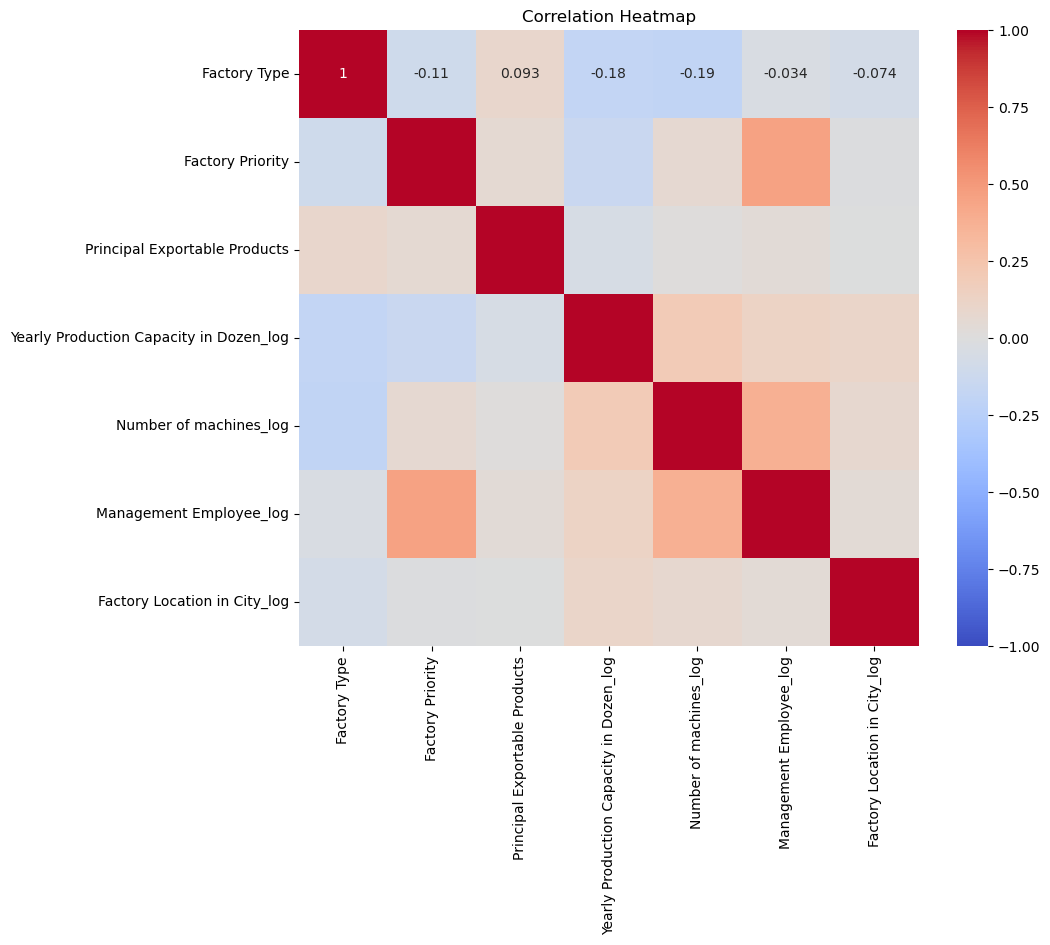

In [28]:
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Data Preprocessing

### In this phase, I removed null values and handled outliers with log transformation. 

In [4]:
data.columns

Index(['Factory Type', 'Factory Priority', 'Management Employee',
       'Number of machines', 'Principal Exportable Products',
       'Factory Location in City', 'Yearly Production Capacity in Dozen'],
      dtype='object')

In [5]:
data.isnull().sum()


Factory Type                             0
Factory Priority                        70
Management Employee                    100
Number of machines                       0
Principal Exportable Products           59
Factory Location in City                 0
Yearly Production Capacity in Dozen      0
dtype: int64

In [6]:
columns_to_fill = ['Factory Priority', 'Management Employee', 'Principal Exportable Products']

# Filled  NaN values with column-wise medians
for column in columns_to_fill:
    mean_value = data[column].median()
    data[column].fillna(mean_value, inplace=True)
    
#Checking NaN values agaim
data.isnull().sum()

Factory Type                           0
Factory Priority                       0
Management Employee                    0
Number of machines                     0
Principal Exportable Products          0
Factory Location in City               0
Yearly Production Capacity in Dozen    0
dtype: int64

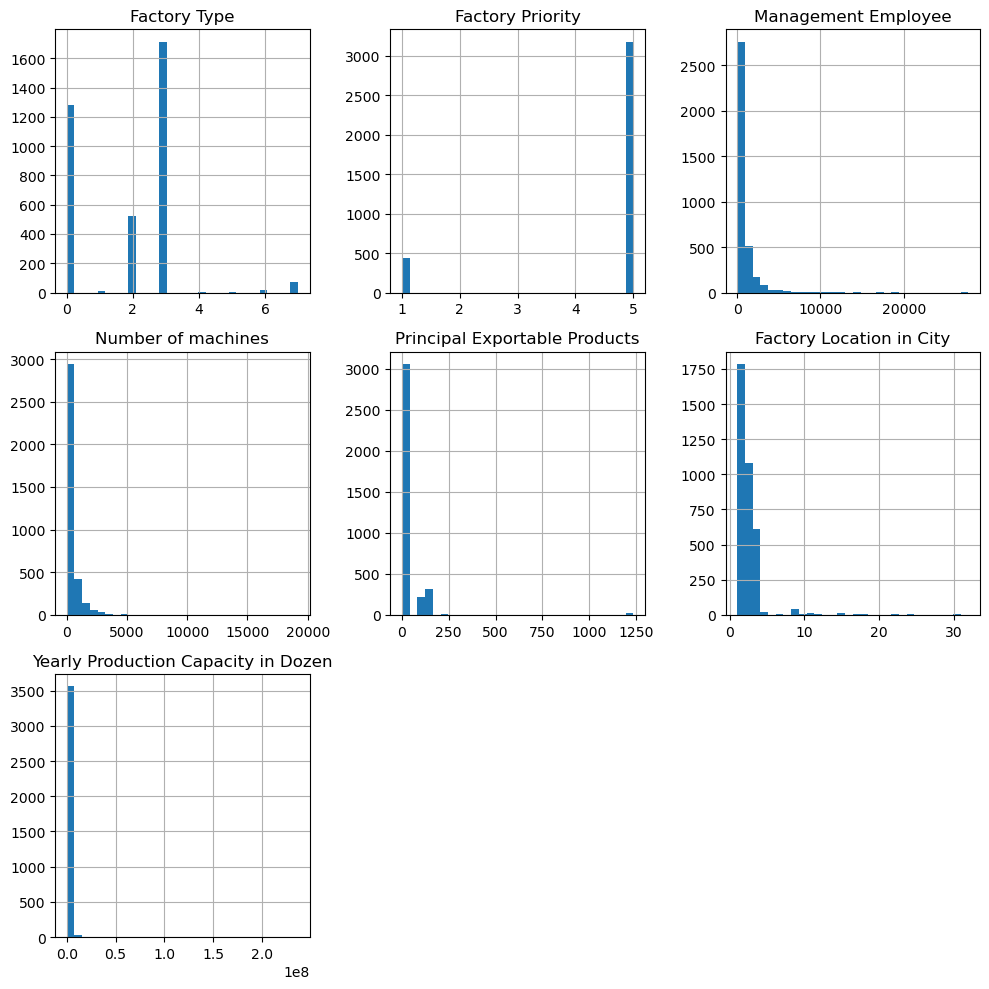

In [7]:
# Plotting histograms for all numeric columns
data.hist(figsize=(10, 10), bins=30)

# Displaying the plots
plt.tight_layout()  # Adjusts the plots to fit better
plt.show()


In [8]:
#Finding maximum and minimum values of the comlumns which were affecting the model's predictive capacity the most

max_productions = data['Yearly Production Capacity in Dozen'].max()
min_productions = data['Yearly Production Capacity in Dozen'].min()

print(f"Highest value in 'Production Capacity in Dozens': {max_productions}")
print(f"Lowest value in 'Production Capacity in Dozens': {min_productions}")

max_machines = data['Number of machines'].max()
min_machines = data['Number of machines'].min()

print(f"Highest value in 'Number of machines': {max_machines}")
print(f"Lowest value in 'Number of machines': {min_machines}")

max_managers = data['Management Employee'].max()
min_managers = data['Management Employee'].min()

print(f"Highest value in 'Management Employee': {max_managers}")
print(f"Lowest value in 'Management Employee': {min_managers}")

Highest value in 'Production Capacity in Dozens': 237000000.0
Lowest value in 'Production Capacity in Dozens': 249.0
Highest value in 'Number of machines': 19200
Lowest value in 'Number of machines': 0
Highest value in 'Management Employee': 27772.0
Lowest value in 'Management Employee': 0.0


### Binnning columns to handle outlier.

In [9]:
num_bins_equal_width = 10

# Calculating bin width
bin_width = (max_machines - min_machines) / num_bins_equal_width

# Creating bin edges using numpy.arange
bins_equal_width = np.arange(min_machines, max_machines + bin_width, bin_width)

# pandas cut function to assign data points to bins
data['Bin_Equal_Width'] = pd.cut(data['Number of machines'], bins_equal_width)
print(data['Bin_Equal_Width'].value_counts())

Bin_Equal_Width
(0.0, 1920.0]         3406
(1920.0, 3840.0]        90
(3840.0, 5760.0]        13
(5760.0, 7680.0]         5
(7680.0, 9600.0]         2
(9600.0, 11520.0]        1
(17280.0, 19200.0]       1
(11520.0, 13440.0]       0
(13440.0, 15360.0]       0
(15360.0, 17280.0]       0
Name: count, dtype: int64


In [10]:
num_bins_equal_width = 10

# Calculating bin width
bin_width = (max_managers - min_managers) / num_bins_equal_width

# Creating bin edges using numpy.arange
bins_equal_width = np.arange(min_managers, max_managers + bin_width, bin_width)

#pandas cut function to assign data points to bins
data['Bin_Equal_Width'] = pd.cut(data['Management Employee'], bins_equal_width)
print(data['Bin_Equal_Width'].value_counts())

Bin_Equal_Width
(0.0, 2777.2]         3414
(2777.2, 5554.4]       140
(5554.4, 8331.6]        26
(8331.6, 11108.8]        6
(13886.0, 16663.2]       3
(11108.8, 13886.0]       2
(16663.2, 19440.4]       2
(24994.8, 27772.0]       1
(19440.4, 22217.6]       0
(22217.6, 24994.8]       0
(27772.0, 30549.2]       0
Name: count, dtype: int64


In [11]:
num_bins_equal_width = 10

# Calculating bin width
bin_width = (max_productions - min_productions) / num_bins_equal_width

# Creating bin edges using numpy.arange
bins_equal_width = np.arange(min_productions, max_productions + bin_width, bin_width)

#pandas cut function to assign data points to bins
data['Bin_Equal_Width'] = pd.cut(data['Yearly Production Capacity in Dozen'], bins_equal_width)
print(data['Bin_Equal_Width'].value_counts())

Bin_Equal_Width
(249.0, 23700224.1]           3596
(23700224.1, 47400199.2]        10
(47400199.2, 71100174.3]         3
(142200099.6, 165900074.7]       2
(71100174.3, 94800149.4]         1
(94800149.4, 118500124.5]        1
(118500124.5, 142200099.6]       1
(213300024.9, 237000000.0]       1
(165900074.7, 189600049.8]       0
(189600049.8, 213300024.9]       0
Name: count, dtype: int64


### Log Transformation

In [12]:
# List of columns to apply log transformation
columns_to_transform = ['Yearly Production Capacity in Dozen', 'Number of machines', 'Management Employee','Factory Location in City']

for column in columns_to_transform:
    data[column + '_log'] = np.log(data[column] + 1)  # Adding 1 to avoid log(0)


In [13]:
from scipy.stats import skew

# Checking skewness before transformation
for column in columns_to_transform:
    print(f"Skewness of {column}: {skew(data[column])}")

# Checking skewness after transformation
for column in columns_to_transform:
    print(f"Skewness of {column}_log: {skew(data[column + '_log'])}")


Skewness of Yearly Production Capacity in Dozen: 22.721537604000215
Skewness of Number of machines: 8.772952213261798
Skewness of Management Employee: 7.128106168023844
Skewness of Factory Location in City: 5.423442284506252
Skewness of Yearly Production Capacity in Dozen_log: 0.7179493405080027
Skewness of Number of machines_log: -1.8097093958764545
Skewness of Management Employee_log: -1.7858899639825365
Skewness of Factory Location in City_log: 1.0534875276677629


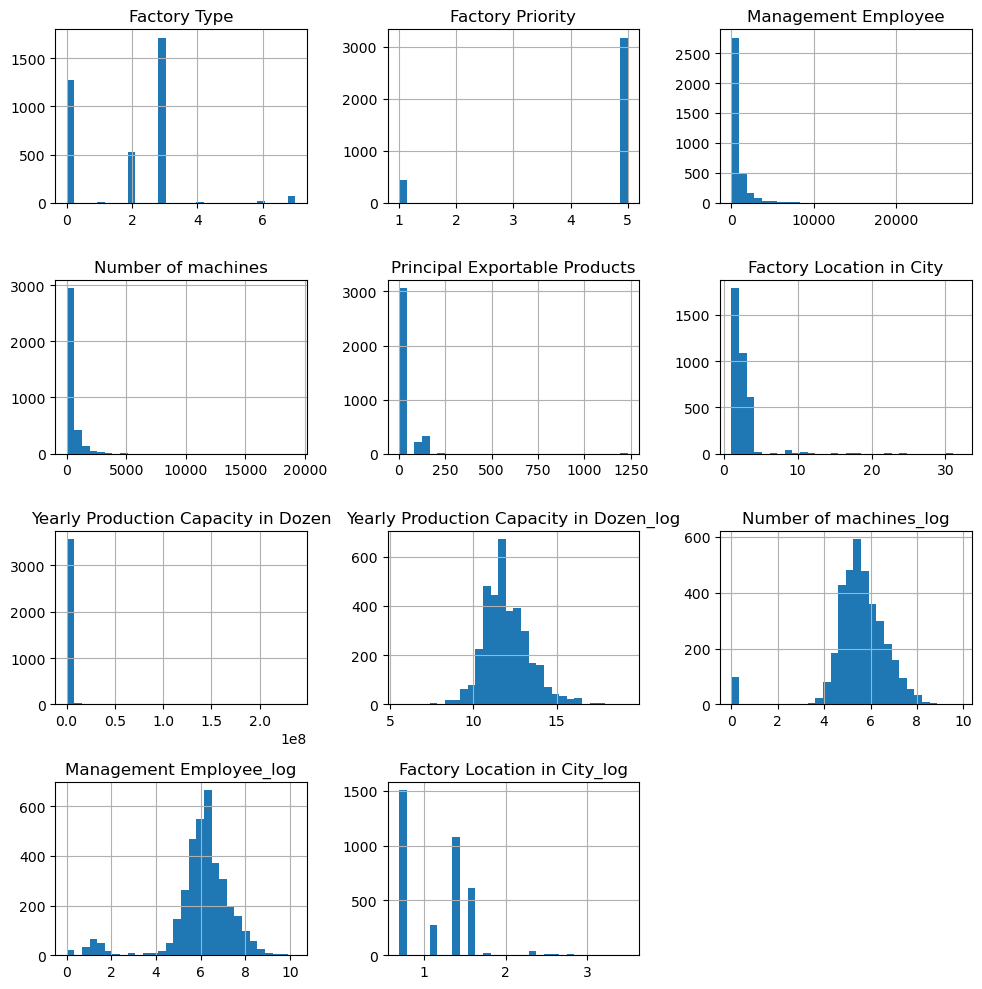

In [14]:
# Plotting histograms for all numeric columns
data.hist(figsize=(10, 10), bins=30)

# Display the plots
plt.tight_layout()  # Adjusts the plots to fit better
plt.show()


In [15]:
#Normalizing Data
scaler = MinMaxScaler()

cols_to_normalize = ['Factory Priority', 'Management Employee_log', 'Number of machines_log', 'Principal Exportable Products', 'Factory Location in City_log','Yearly Production Capacity in Dozen_log' ]

# Normalizing the selected columns
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

#Dropping columns to avoid repetition
data = data.drop(columns=['Number of machines','Yearly Production Capacity in Dozen', 'Factory Location in City',
                          'Bin_Equal_Width', 'Management Employee'])
data.head(10)

,Factory Type,Factory Priority,Principal Exportable Products,Yearly Production Capacity in Dozen_log,Number of machines_log,Management Employee_log,Factory Location in City_log
0,3,1.0,0.009732,0.435360,0.467936,0.508072,0.247256
1,0,1.0,0.000000,0.565555,0.481098,0.572800,0.000000
2,0,1.0,0.000000,0.435360,0.482846,0.540026,0.144635
3,0,1.0,0.009732,0.318416,0.565356,0.540026,0.000000
4,0,1.0,0.000000,0.414456,0.402556,0.409473,0.000000
5,2,1.0,0.000000,0.398242,0.609990,0.622390,0.000000
6,3,1.0,0.008921,0.251841,0.516465,0.595109,0.000000
7,3,0.0,0.009732,0.526390,0.568010,0.067744,0.247256
8,2,1.0,0.000000,0.398242,0.710146,0.643290,0.000000
9,0,1.0,0.008921,0.435360,0.570959,0.605406,0.000000


## Model Training

### K- Fold Cross Validation has been used with each model to ensure a reliable estimation of model performance.

In [16]:
#X- Features, Y- Target
X = data[['Factory Type', 'Factory Priority', 'Management Employee_log',
           'Number of machines_log', 'Principal Exportable Products',
           'Factory Location in City_log']]
y = data['Yearly Production Capacity in Dozen_log']

### Linear Regression

In [17]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_mse_scores = []
val_mse_scores = []
val_r2_scores = []

# Initialize the Linear Regression model
linear_regressor = LinearRegression()

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the Linear Regression model
    linear_regressor.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = linear_regressor.predict(X_train)
    y_val_pred = linear_regressor.predict(X_val)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Append scores
    train_mse_scores.append(train_mse)
    val_mse_scores.append(val_mse)
    val_r2_scores.append(val_r2)

#Train-Test Split on the entire dataset
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit Linear Regression model on the training set
linear_regressor.fit(X_train_final, y_train_final)

#Make predictions on the train and test sets
y_train_final_pred = linear_regressor.predict(X_train_final)
y_test_final_pred = linear_regressor.predict(X_test_final)

#Evaluate performance on the train and test sets
train_mse_test = mean_squared_error(y_train_final, y_train_final_pred)
test_mse_test = mean_squared_error(y_test_final, y_test_final_pred)
train_r2_test = r2_score(y_train_final, y_train_final_pred)
test_r2_test = r2_score(y_test_final, y_test_final_pred)

# Final results
print("\n--- K-Fold Cross-Validation Results ---")
print(f"Train MSE across folds: {train_mse_scores}")
print(f"Validation MSE across folds: {val_mse_scores}")
print(f"Mean Validation MSE: {np.mean(val_mse_scores)}")
print(f"R-squared scores for validation: {val_r2_scores}")
print(f"Mean R-squared for validation: {np.mean(val_r2_scores)}")

print("\n--- Final Train-Test Split Results ---")
print(f"Train MSE: {train_mse_test}")
print(f"Test MSE: {test_mse_test}")
print(f"Train R-squared: {train_r2_test}")
print(f"Test R-squared: {test_r2_test}")


--- K-Fold Cross-Validation Results ---
Train MSE across folds: [0.00926599276731359, 0.00913757504163313, 0.009286283551578137, 0.009123861018336043, 0.00927347472444942]
Validation MSE across folds: [0.009077279159512567, 0.009592135366722864, 0.009001198573373385, 0.009651617751329025, 0.009041008216360627]
Mean Validation MSE: 0.009272647813459694
R-squared scores for validation: [0.1277440412598212, 0.12333878504718687, 0.11190748145031992, 0.09243477224815289, 0.13981525019819285]
Mean R-squared for validation: 0.11904806604073474

--- Final Train-Test Split Results ---
Train MSE: 0.009265992767313588
Test MSE: 0.009077279159512567
Train R-squared: 0.12240378868743984
Test R-squared: 0.1277440412598212


### Random Forest Regression

In [18]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_mse_scores = []
val_mse_scores = []
val_r2_scores = []

# Initialize the Random Forest Regressor model
rfr_model = RandomForestRegressor(random_state=42)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the Random Forest Regressor model
    rfr_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = rfr_model.predict(X_train)
    y_val_pred = rfr_model.predict(X_val)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Append scores
    train_mse_scores.append(train_mse)
    val_mse_scores.append(val_mse)
    val_r2_scores.append(val_r2)

# Train-Test Split on the entire dataset
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest Regressor model on the training set
rfr_model.fit(X_train_final, y_train_final)

# Make predictions on the train and test sets
y_train_final_pred = rfr_model.predict(X_train_final)
y_test_final_pred = rfr_model.predict(X_test_final)

# Evaluate performance on the train and test sets
train_mse_test = mean_squared_error(y_train_final, y_train_final_pred)
test_mse_test = mean_squared_error(y_test_final, y_test_final_pred)
train_r2_test = r2_score(y_train_final, y_train_final_pred)
test_r2_test = r2_score(y_test_final, y_test_final_pred)

# Final results
print("\n--- K-Fold Cross-Validation Results ---")
print(f"Train MSE across folds: {train_mse_scores}")
print(f"Validation MSE across folds: {val_mse_scores}")
print(f"Mean Validation MSE: {np.mean(val_mse_scores)}")
print(f"R-squared scores for validation: {val_r2_scores}")
print(f"Mean R-squared for validation: {np.mean(val_r2_scores)}")

print("\n--- Final Train-Test Split Results ---")
print(f"Train MSE: {train_mse_test}")
print(f"Test MSE: {test_mse_test}")
print(f"Train R-squared: {train_r2_test}")
print(f"Test R-squared: {test_r2_test}")


--- K-Fold Cross-Validation Results ---
Train MSE across folds: [0.0013289096504698304, 0.0012217815750064592, 0.0013467648223561234, 0.001224515020315679, 0.0012880492329492219]
Validation MSE across folds: [0.007510000353286927, 0.008461702598752882, 0.007402388139979072, 0.00923085736519233, 0.008427920234895669]
Mean Validation MSE: 0.008206573738421376
R-squared scores for validation: [0.27834735021555423, 0.22665327404293711, 0.26965220543373136, 0.13199990065582545, 0.1981460158962709]
Mean R-squared for validation: 0.2209597492488638

--- Final Train-Test Split Results ---
Train MSE: 0.0013339058156434918
Test MSE: 0.007599596431608997
Train R-squared: 0.8736637595718835
Test R-squared: 0.26973786362570096


### Feature Importance Plot

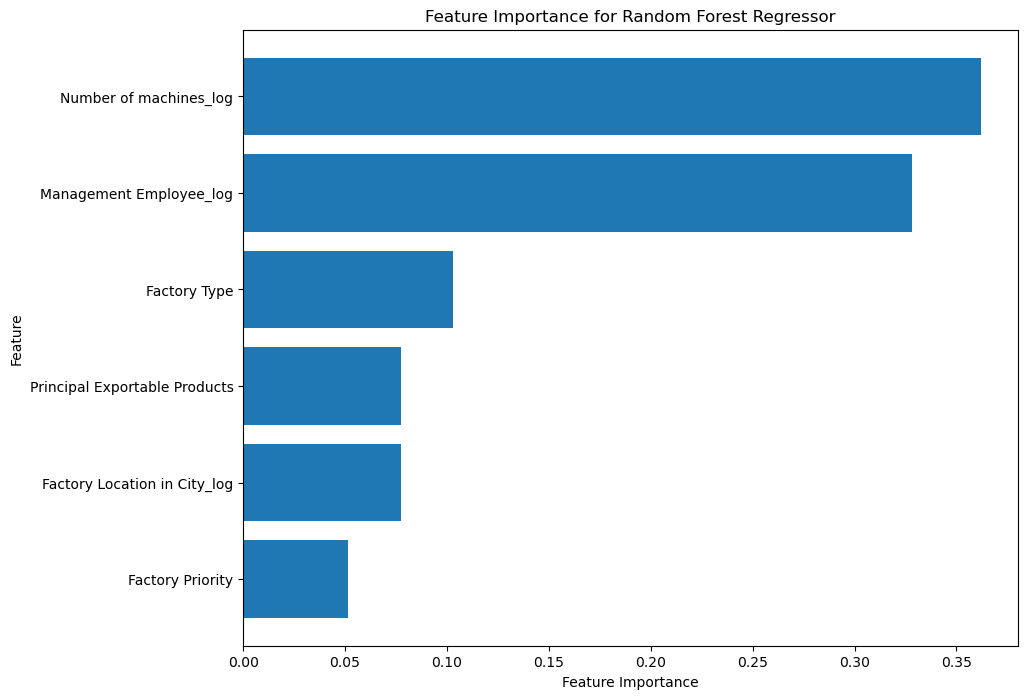

In [19]:
# Get feature importances from the trained Random Forest model
feature_importances = rfr_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Regressor')
plt.show()


### CatBoost Regression

In [20]:
#K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_mse_scores = []
val_mse_scores = []
val_r2_scores = []

for train_index, val_index in kf.split(X):
    # Train-Test Split within each fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit CatBoost Regressor model
    model = CatBoostRegressor(learning_rate=0.1, depth=6, iterations=100, random_state=42, silent=True)
    model.fit(X_train, y_train)
    
    # Predictions on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate performance for both train and validation sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    train_mse_scores.append(train_mse)
    val_mse_scores.append(val_mse)
    val_r2_scores.append(val_r2)

# Train-Test Split on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit CatBoost Regressor model on the training set
model = CatBoostRegressor(learning_rate=0.1, depth=6, iterations=100, random_state=42, silent=True)
model.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance on the train and test sets
train_mse_test = mean_squared_error(y_train, y_train_pred)
test_mse_test = mean_squared_error(y_test, y_test_pred)
train_r2_test = r2_score(y_train, y_train_pred)
test_r2_test = r2_score(y_test, y_test_pred)

# Final results
print("\n--- K-Fold Cross-Validation Results ---")
print(f"Train MSE across folds: {train_mse_scores}")
print(f"Validation MSE across folds: {val_mse_scores}")
print(f"Mean Validation MSE: {np.mean(val_mse_scores)}")
print(f"R-squared scores for validation: {val_r2_scores}")
print(f"Mean R-squared for validation: {np.mean(val_r2_scores)}")

print("\n--- Final Train-Test Split Results ---")
print(f"Train MSE: {train_mse_test}")
print(f"Test MSE: {test_mse_test}")
print(f"Train R-squared: {train_r2_test}")
print(f"Test R-squared: {test_r2_test}")



--- K-Fold Cross-Validation Results ---
Train MSE across folds: [0.0062632371260894415, 0.006042787993692625, 0.006240933980043875, 0.006003174520188819, 0.006055644787119932]
Validation MSE across folds: [0.0068116678284366435, 0.007668912870329858, 0.0068160715901493625, 0.00807661991418463, 0.007506124854838269]
Mean Validation MSE: 0.007375879411587752
R-squared scores for validation: [0.3454516768842344, 0.29910929972962297, 0.32750042832994963, 0.24053567176624546, 0.2858479966253976]
Mean R-squared for validation: 0.29968901466708997

--- Final Train-Test Split Results ---
Train MSE: 0.0062520099073814965
Test MSE: 0.006867018994343832
Train R-squared: 0.40786267099609275
Test R-squared: 0.3401328601510103


### Decision Tree Regression

In [21]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_mse_scores = []
val_mse_scores = []
val_r2_scores = []

for train_index, val_index in kf.split(X):
    # Train-Test Split within each fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit Decision Tree Regressor model
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate performance for both train and validation sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    train_mse_scores.append(train_mse)
    val_mse_scores.append(val_mse)
    val_r2_scores.append(val_r2)

# Train-Test Split on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Decision Tree Regressor model on the training set
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance on the train and test sets
train_mse_test = mean_squared_error(y_train, y_train_pred)
test_mse_test = mean_squared_error(y_test, y_test_pred)
train_r2_test = r2_score(y_train, y_train_pred)
test_r2_test = r2_score(y_test, y_test_pred)

# Final results
print("\n--- K-Fold Cross-Validation Results ---")
print(f"Train MSE across folds: {train_mse_scores}")
print(f"Validation MSE across folds: {val_mse_scores}")
print(f"Mean Validation MSE: {np.mean(val_mse_scores)}")
print(f"R-squared scores for validation: {val_r2_scores}")
print(f"Mean R-squared for validation: {np.mean(val_r2_scores)}")

print("\n--- Final Train-Test Split Results ---")
print(f"Train MSE: {train_mse_test}")
print(f"Test MSE: {test_mse_test}")
print(f"Train R-squared: {train_r2_test}")
print(f"Test R-squared: {test_r2_test}")


--- K-Fold Cross-Validation Results ---
Train MSE across folds: [0.00020857433443836814, 0.00012942304395373075, 0.00021597161635970473, 0.0001629620750321983, 0.0001788448737839205]
Validation MSE across folds: [0.013816859733300867, 0.015719220569379442, 0.013616288789809562, 0.016404515035611213, 0.014028046235008406]
Mean Validation MSE: 0.0147169860726219
R-squared scores for validation: [-0.327692805483365, -0.43663850390087755, -0.3434348888172374, -0.5425566788948926, -0.33466435956035756]
Mean R-squared for validation: -0.396997447331346

--- Final Train-Test Split Results ---
Train MSE: 0.00020857433443836814
Test MSE: 0.014048446697345299
Train R-squared: 0.9802456088325634
Test R-squared: -0.34994651232707397


### Support Vector Regression

In [22]:
#K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_mse_scores = []
val_mse_scores = []
val_r2_scores = []

for train_index, val_index in kf.split(X):
    # Train-Test Split within each fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Initialize the SVR model
    svr_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # You can adjust the kernel, C, and epsilon as needed
    
    # Train the SVR model
    svr_regressor.fit(X_train, y_train)
    
    # Predictions on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate performance for both train and validation sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    train_mse_scores.append(train_mse)
    val_mse_scores.append(val_mse)
    val_r2_scores.append(val_r2)

# Train-Test Split on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit XGBoost Regressor model on the training set
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance on the train and test sets
train_mse_test = mean_squared_error(y_train, y_train_pred)
test_mse_test = mean_squared_error(y_test, y_test_pred)
train_r2_test = r2_score(y_train, y_train_pred)
test_r2_test = r2_score(y_test, y_test_pred)

# Final results
print("\n--- K-Fold Cross-Validation Results ---")
print(f"Train MSE across folds: {train_mse_scores}")
print(f"Validation MSE across folds: {val_mse_scores}")
print(f"Mean Validation MSE: {np.mean(val_mse_scores)}")
print(f"R-squared scores for validation: {val_r2_scores}")
print(f"Mean R-squared for validation: {np.mean(val_r2_scores)}")

print("\n--- Final Train-Test Split Results ---")
print(f"Train MSE: {train_mse_test}")
print(f"Test MSE: {test_mse_test}")
print(f"Train R-squared: {train_r2_test}")
print(f"Test R-squared: {test_r2_test}")



--- K-Fold Cross-Validation Results ---
Train MSE across folds: [0.00020857433443836814, 0.0036345599631501914, 0.0037000155225125728, 0.0036716638616905556, 0.0036822821048068176]
Validation MSE across folds: [0.014048446697345302, 0.00035890789858956636, 9.699512786291225e-05, 0.00021044098506636414, 0.00016795332623462984]
Mean Validation MSE: 0.0029765488070197547
R-squared scores for validation: [-0.3499465123270742, 0.9671980614947069, 0.9904300914274199, 0.9802117193758757, 0.9840204890374857]
Mean R-squared for validation: 0.7143827698016827

--- Final Train-Test Split Results ---
Train MSE: 0.00182759229165492
Test MSE: 0.008377591163131484
Train R-squared: 0.8269059655822073
Test R-squared: 0.19497861820491835


### XGBoost Regression

In [23]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_mse_scores = []
val_mse_scores = []
val_r2_scores = []

for train_index, val_index in kf.split(X):
    # Train-Test Split within each fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit XGBoost Regressor model
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate performance for both train and validation sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    train_mse_scores.append(train_mse)
    val_mse_scores.append(val_mse)
    val_r2_scores.append(val_r2)

# Train-Test Split on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit XGBoost Regressor model on the training set
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance on the train and test sets
train_mse_test = mean_squared_error(y_train, y_train_pred)
test_mse_test = mean_squared_error(y_test, y_test_pred)
train_r2_test = r2_score(y_train, y_train_pred)
test_r2_test = r2_score(y_test, y_test_pred)

# Final results
print("\n--- K-Fold Cross-Validation Results ---")
print(f"Train MSE across folds: {train_mse_scores}")
print(f"Validation MSE across folds: {val_mse_scores}")
print(f"Mean Validation MSE: {np.mean(val_mse_scores)}")
print(f"R-squared scores for validation: {val_r2_scores}")
print(f"Mean R-squared for validation: {np.mean(val_r2_scores)}")

print("\n--- Final Train-Test Split Results ---")
print(f"Train MSE: {train_mse_test}")
print(f"Test MSE: {test_mse_test}")
print(f"Train R-squared: {train_r2_test}")
print(f"Test R-squared: {test_r2_test}")



--- K-Fold Cross-Validation Results ---
Train MSE across folds: [0.00182759229165492, 0.0016917815844342248, 0.0017364776180212999, 0.0016391547848749394, 0.0017183017075242102]
Validation MSE across folds: [0.008377591163131484, 0.008758657856052092, 0.008217116161014254, 0.00989495874400992, 0.008857264232170611]
Mean Validation MSE: 0.008821117631275672
R-squared scores for validation: [0.19497861820491835, 0.1995134197041747, 0.18926803723256647, 0.06955282342528468, 0.15729712492783443]
Mean R-squared for validation: 0.1621220046989557

--- Final Train-Test Split Results ---
Train MSE: 0.00182759229165492
Test MSE: 0.008377591163131484
Train R-squared: 0.8269059655822073
Test R-squared: 0.19497861820491835


## Ensemble Techniques

### CBRF with Linear Regression

In [24]:
# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize empty arrays for base model predictions
random_forest_preds = np.zeros(len(X))
catboost_preds = np.zeros(len(X))

# Train base models using K-Fold CV
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    random_forest_preds[test_index] = rf_preds
    
    # CatBoost
    cat_model = CatBoostRegressor(learning_rate=0.1, depth=6, iterations=100, random_state=42, silent=True)
    cat_model.fit(X_train, y_train)
    cat_preds = cat_model.predict(X_test)
    catboost_preds[test_index] = cat_preds

# Stack base model predictions into new feature set
stacked_features = np.column_stack((random_forest_preds, catboost_preds))

# Training a meta-model, Linear Regressio, on the stacked features
meta_model = LinearRegression()
meta_model.fit(stacked_features, y)

# Test the meta-model
meta_model_preds = meta_model.predict(stacked_features)

# Evaluate the final stacked model
mse = mean_squared_error(y, meta_model_preds)
r2_lr = r2_score(y, meta_model_preds )
print(f"Stacked Model MSE: {mse}")
print(f'R-squared (LR): {r2_lr}')

Stacked Model MSE: 0.007349588329394483
R-squared (LR): 0.30190336997666156


### CBRF with XGBoost Regression

In [25]:
# X - features, y - target
X = data[['Factory Type', 'Factory Priority', 'Management Employee_log',
          'Number of machines_log', 'Principal Exportable Products',
          'Factory Location in City_log']]
y = data['Yearly Production Capacity in Dozen_log']

# Split data into 80% train and 20% test
X_train, X_blend, y_train, y_blend = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest model on 80% of the data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Training CatBoost model on 80% of the data
catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42, silent=True)
catboost_model.fit(X_train, y_train)

# Making predictions on the 20% blend set using both models
rf_preds = rf_model.predict(X_blend)
catboost_preds = catboost_model.predict(X_blend)

# Creating a DataFrame to store the predictions as features
blend_predictions = pd.DataFrame({
    'RandomForest_Pred': rf_preds,
    'CatBoost_Pred': catboost_preds
})


# Train XGBoost as the meta-model on the blend predictions
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(blend_predictions, y_blend)

# Make final predictions using XGBoost
final_predictions_xgb = xgb_model.predict(blend_predictions)

# Evaluate the performance
mse_xgb = mean_squared_error(y_blend, final_predictions_xgb)
r2_xgb = r2_score(y_blend, final_predictions_xgb)

print(f'MSE (XGBoost): {mse_xgb}')
print(f'R-squared (XGBoost): {r2_xgb}')



MSE (XGBoost): 0.00170832513519527
R-squared (XGBoost): 0.8358432353511852
